<a href="https://colab.research.google.com/github/jvataidee/SpatialDataSience/blob/master/Classificacao_DL_Usando_ArcGIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificando com Deep Learning usando ArcGIS

In [ ]:
#Importar bibliotecas importantes
import arcpy
from arcpy import env
import os 
from arcpy.ia import *
env.overwriteOutput = True

In [ ]:
#Diretorio de workspace
workspace = r"F:\diretorio\model.gdb"
workspace2 = r"F:\diretorio\model"

In [ ]:
#Diretório
out_poligon = os.path.join(workspace, 'poligons')
classificada = os.path.join(workspace2, 'classified.tif')

In [ ]:
#Raster to polygon
arcpy.conversion.RasterToPolygon(classificada,
                                     out_poligon,
                                     "SIMPLIFY",
                                     "Classvalue",
                                     "SINGLE_OUTER_PART",
                                     None)

In [ ]:
#Imagem para classificar
input_imagem = os.path.join(workspace2, 'clip.tif')
out_amostras = os.path.join(workspace2, 'amostra')

In [ ]:
arcpy.ia.ExportTrainingDataForDeepLearning(input_imagem ,
                                           out_amostras ,
                                           out_poligon,
                                           "TIFF",
                                           256, 256, 128, 128,
                                           "ONLY_TILES_WITH_FEATURES",
                                           "Classified_Tiles",
                                           0, "gridcode",
                                           0, None, 0,
                                           "MAP_SPACE",
                                           "PROCESS_AS_MOSAICKED_IMAGE",
                                           "NO_BLACKEN",
                                           "FIXED_SIZE",
                                           None)

## Treinando o modelo

In [ ]:
from arcgis.learn import *

In [ ]:
#ler as amostras
data = prepare_data(out_amostras, 
                    batch_size= 2, 
                    dataset_type="Classified_Tiles", 
                    chip_size = 256)

In [ ]:
#Configurando modelo
model = UnetClassifier(data, backbone = "resnet34")

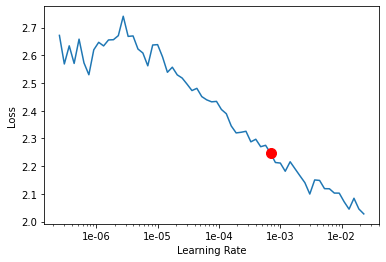

Learning Rate: 0.0006918309709189362


In [ ]:
#Learning Rate
lr = model.lr_find()
print("Learning Rate:",lr)

In [ ]:
model.fit(2, lr =lr) 

epoch     train_loss  valid_loss  accuracy  dice      time    
0         0.769504    0.484952    0.813833  0.763322  03:53     
1         0.515143    0.377563    0.848075  0.805098  04:00     
Using matplotlib backend: TkAgg


In [ ]:
model.per_class_metrics()

,NoData,10,20,30,40
precision,0.999306,0.986833,0.758312,0.715738,0.797803
recall,0.998812,0.990303,0.289700,0.829067,0.881818
f1,0.999059,0.988565,0.419237,0.768246,0.837709


In [ ]:
model.mIOU()

{'0': 0.5838231805903785, '10': 0.7593263823289166, '20': 0.2334648998666519, '30': 0.5908736642615711, '40': 0.6990178531631893}

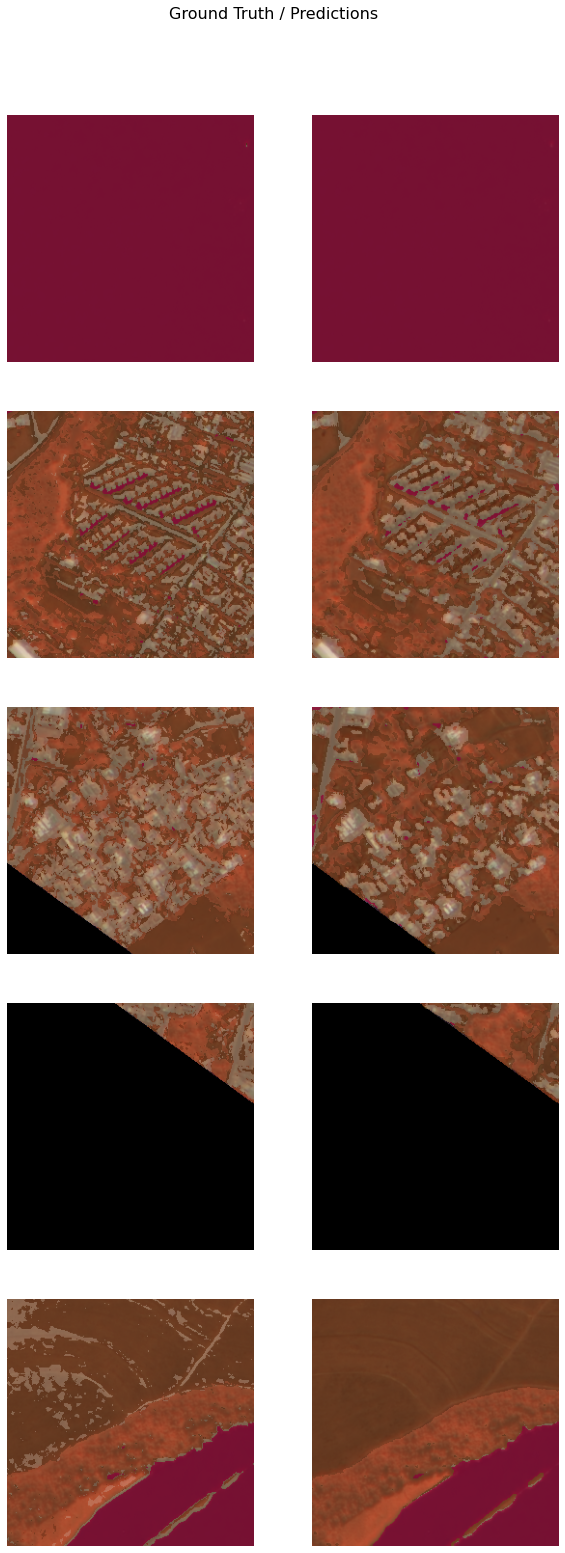

In [ ]:
model.show_results()

In [ ]:
#salvar modelo
model.save('model_UNET')

## Classificando uma nova imagem

In [ ]:
#Configurações de classificação
nova_imagem = os.path.join(workspace2, 'imagem2.tif')
modelo = os.path.join(workspace2, 'F:\diretorio\model\model_UNET.dlpk')

parametros = "padding 56;batch_size 4;predict_background True;tile_size 256"

#Diretório de classificação
out_new_classified = r"F:\diretorio\model.gdb\imagem2_Classify"

In [ ]:
with arcpy.EnvManager(processorType="GPU"):
    out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning(nova_imagem, modelo , parametros, "PROCESS_AS_MOSAICKED_IMAGE", None); out_classified_raster.save(out_new_classified)